<a href="https://colab.research.google.com/github/JayNguyen-123/Satellite_Images_classification/blob/main/SatelliteImagesClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Classifying Satellite Images in PyToch
- Using CNN along with ResNets, this model classifies the images taken by a satellite into 4 different classes: cloudy, desert, green area, and water.

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torchvision.transforms as transform
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

project_name = '05b-image_classification-resnet'


In [2]:
# importing and splitting the data into train and test
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
data_dir = '/content/drive/MyDrive/Satellite Images/data'
print(os.listdir(data_dir))


['desert', 'water', 'cloudy', 'green_area']


In [4]:
# Data transforms (normalization and data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.199
                                    , 0.2010))
train_transform = transform.Compose([transform.RandomCrop(64, padding=4, padding_mode='reflect'),
                                      transform.RandomHorizontalFlip(),
                                      transform.ToTensor(),
                                      transform.Normalize(*stats, inplace=True)])
valid_transform = transform.Compose([transform.ToTensor(), transform.Normalize(*stats)])


In [5]:
from torchvision import datasets, transforms, models

train_transform = transforms.Compose([transforms.Resize(64), transforms.ToTensor(),])
test_transform = transforms.Compose([transforms.Resize(64), transforms.ToTensor(),])

train_data = datasets.ImageFolder(data_dir, transform=train_transform)
test_data = datasets.ImageFolder(data_dir, transform=test_transform)

batch_size =8


In [6]:
train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(test_data, batch_size*2, num_workers=2, pin_memory=True)


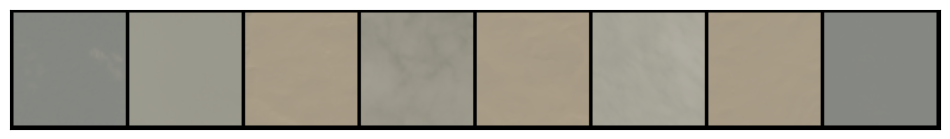

In [7]:
def denormalize(images, means, stds):
  means = torch.tensor(means).reshape(1, 3, 1, 1)
  stds = torch.tensor(stds).reshape(1, 3, 1, 1)
  return images * stds + means

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_xticks([])
    ax.set_yticks([])
    denorm_images = denormalize(images, *stats)
    ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
    break

show_batch(train_dl)


In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)



In [10]:
device = get_default_device()
device


device(type='cuda')

In [11]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)



In [12]:
class SimpleResidualBlock(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
    self.relu2 = nn.ReLU()

  def forward(self, x):
    out = self.conv1(x)
    out = self.relu1(out)
    out = self.conv2(out)
    return self.relu2(out) + x


In [13]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
  out = simple_resnet(images)
  print(out.shape)
  break



torch.Size([8, 3, 64, 64])


In [14]:
del simple_resnet, images, labels
torch.cuda.empty_cache()


In [26]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lr'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [16]:
def conv_block(in_channels, out_channels, pool=False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True)]

  if pool:
    layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
  def __init__(self, in_channels, num_classes):
    super().__init__()
    self.conv1 = conv_block(in_channels, 64)
    self.conv2 = conv_block(64, 128, pool=True)
    self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
    self.conv3 = conv_block(128, 256, pool=True)
    self.conv4 = conv_block(256, 512, pool=True)
    self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
    self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                    nn.Flatten(),
                                    nn.Dropout(0.2),
                                    nn.Linear(512, num_classes))

  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.classifier(out)
    return out





In [17]:
model = to_device(ResNet9(3, 4), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [28]:
# Training the model

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history











In [19]:
# Evaluating the model

history = [evaluate(model, valid_dl)]
history


[{'val_loss': 1.386072039604187, 'val_acc': 0.26651278138160706}]

In [20]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [29]:
# Visualizing loss

history = fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)


Epoch [0], last_lr: 0.00280, train_loss: 0.5194, val_loss: 0.7692, val_acc: 0.6575
Epoch [1], last_lr: 0.00760, train_loss: 0.9524, val_loss: 1.5727, val_acc: 0.6091
Epoch [2], last_lr: 0.01000, train_loss: 0.9005, val_loss: 0.7147, val_acc: 0.7767
Epoch [3], last_lr: 0.00950, train_loss: 0.6978, val_loss: 0.4555, val_acc: 0.7941
Epoch [4], last_lr: 0.00812, train_loss: 0.5975, val_loss: 0.3276, val_acc: 0.8801
Epoch [5], last_lr: 0.00611, train_loss: 0.5027, val_loss: 0.4610, val_acc: 0.8087
Epoch [6], last_lr: 0.00389, train_loss: 0.4223, val_loss: 0.2684, val_acc: 0.9051
Epoch [7], last_lr: 0.00188, train_loss: 0.3843, val_loss: 0.2387, val_acc: 0.9026
Epoch [8], last_lr: 0.00050, train_loss: 0.2996, val_loss: 0.1573, val_acc: 0.9510
Epoch [9], last_lr: 0.00000, train_loss: 0.2400, val_loss: 0.1323, val_acc: 0.9602


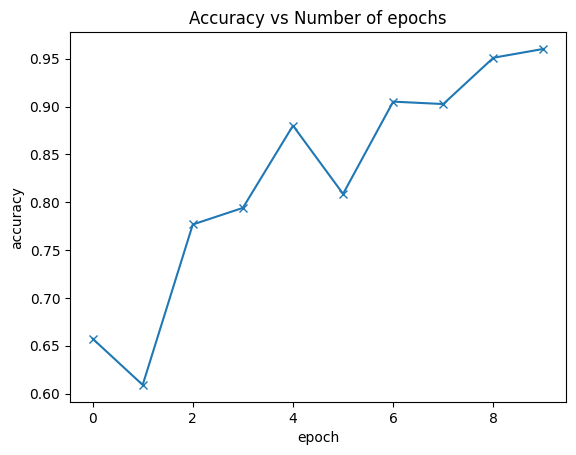

In [30]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs Number of epochs')

plot_accuracies(history)


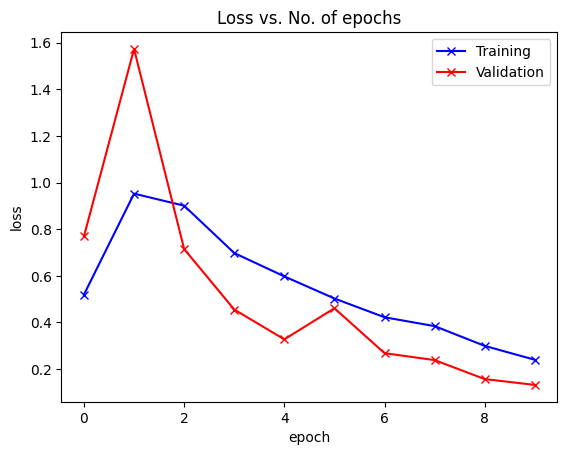

In [31]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

plot_losses(history)

Label:  cloudy , Predicted:  cloudy


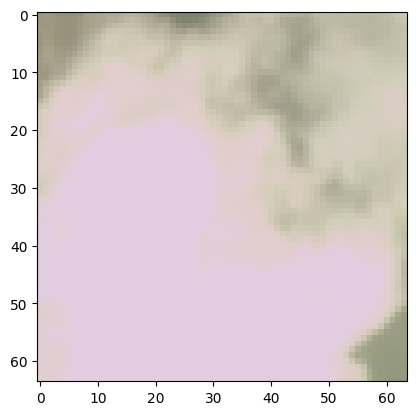

In [32]:
# Test with individual images

def predict_image(img, model):
  # Convert to a batch of 1
  xb = to_device(img.unsqueeze(0), device)

  # Get predictions from model
  yb = model(xb)

  # Pick index with highest probabitity
  _, preds = torch.max(yb, dim=1)

  # Retrieve teh class label
  return train_data.classes[preds[0].item()]

img, label = test_data[0]
plt.imshow(img.permute(1, 2, 0).clamp(0,1))
print('Label: ', train_data.classes[label], ', Predicted: ', predict_image(img, model))
